In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from models.discriminator import get_discriminator
from models.generator import get_generator
from models.encoder import get_encoder
from tqdm import tqdm
from joblib import load
import os
os.environ['CUDA_VISIBLE_DEVICES']='-1'
from pathlib import Path
from os import path
from utils.wasserstein_dist import wasserstein_dist
from utils.loaddata import get_data
import seaborn as sns
import scipy.io

The pedagogical example:

\begin{equation}
        u_{xx} - u^2 u_x = b(x), \hspace{1em} x \in [-1,1]
\end{equation}

with random boundary conditions $u(-1) \sim \mathcal{N}(0, \sigma_1^2)$ and $u(1) \sim \mathcal{N}(0, \sigma_2^2)$, 
where $b(x) = - \pi^2 \sin (\pi x) - \pi \cos (\pi x) \sin^2 (\pi x)$.

The deterministic solution (with $\sigma_1 = \sigma_2 = 0$) is $u(x)=\sin(x)$.

The empirical Loss function is as follows:

$$
\widehat{\text{Loss}} = \min_{g_{\theta} \in \mathcal{G}} \max_{f_{\alpha} \in \mathcal{F}} \frac{1}{m} \sum_{i=1}^m f_{\alpha}(\mathbf{\bar{x}}_i,g_{\theta}(\mathbf{\bar{x}}_i,\mathbf{z}_i)) - \frac{1}{m}\sum_{i=1}^m f_{\alpha}(\mathbf{\bar{x}}_i,\mathbf{u}_i) + \lambda \cdot \frac{1}{k} \sum_{j=1}^k \| \mathcal{L}g_{\theta}(\mathbf{x}_j,\mathbf{z}_j) - \mathbf{b}_j \|_2^2
$$

with observations $\{(\mathbf{\bar{x}}_i,\mathbf{z}_i)\}_{i=1}^m$, $\{(\mathbf{\bar{x}}_i,\mathbf{u}_i)\}_{i=1}^m$ on the boundary and $\{(\mathbf{x}_j,\mathbf{b}_j)\}_{j=1}^k$ in the interior domain.

In [2]:
tf.random.set_seed(666666)
np.random.seed(666666)

# Define some hyper-parameters 
noise_level = 0.05
par_pinns = 1e2 # hyperparameter to balance wgan and pinns regularization term
N_r = 100 # number of training data for residual (k in my paper)
N_u = 20 # number of training data for uncertain boundary/initial conditions (m=n in my paper)
z_shape = 2 # we adopt 2-dimensional standard normal noise as input for uncertainty quantification
g_depth = 3 # depth of generators (D_g)
g_width = 50 # width of generators (W_g)
d_depth = 3 # depth of discriminators (D_f)
d_width = 50 # width of discriminators
lrg = 1e-4 # learning rate for generators
lrd = 1e-4 # learning rate for discriminators
beta_1 = 0.9
beta_2 = 0.99 # those two beta_s are for Adam optimizor.
bjorck_beta = 0.5 
bjorck_iter = 5
bjorck_order = 2 # hyper-parameters for bjorck orthonomalization iteration
group_size = 2 # groupsize of groupsort neural networks
num_itr = 30000 # maximun number of itertions

In [3]:
class WGAN_PINNs(object):

    def __init__(self,
                 noise_level=0.05,
                 N_r=200,
                 N_u=20,
                 X_mean=0,
                 X_std=1,
                 par_pinns=1,
                 z_shape=2,
                 out_dim=1,
                 num_itr=30000,
                 g_depth=3,
                 g_width=50,
                 d_depth=3,
                 d_width=50,
                 lrg=1e-4,
                 lrd=1e-4,
                 beta_1=0.9,
                 beta_2=0.999,
                 bjorck_beta=0.5,
                 bjorck_iter=5,
                 bjorck_order=2,
                 group_size=2):

        self.noise_level = noise_level
        self.N_r = N_r
        self.N_u = N_u
        self.X_mean = X_mean
        self.X_std = X_std
        self.z_shape = z_shape
        self.out_dim = out_dim
        self.num_itr = num_itr
        self.Jacobian = 1 / self.X_std
        self.par_pinns = par_pinns
        self.x_shape = 1
        # update discriminators 2 times and then generators 5 times
        self.k_d = 2
        self.k_g = 5

        self.d_depth = d_depth
        self.d_width = d_width
        self.g_depth = g_depth
        self.g_width = g_width

        # network initialization
        self.G = get_generator(input_shape=(self.z_shape + self.x_shape,), output_shape=self.out_dim, depth=g_depth,
                               width=g_width)
        self.D = get_discriminator(input_shape=(self.out_dim + self.x_shape,), depth=d_depth, width=d_width,
                                   bjorck_beta=bjorck_beta, bjorck_iter=bjorck_iter, bjorck_order=bjorck_order,
                                   group_size=group_size)
        
        # optimizor (Adam) for discriminators and generators
        self.G_optimizer = Adam(learning_rate=lrg, beta_1=beta_1, beta_2=beta_2)
        self.D_optimizer = Adam(learning_rate=lrd, beta_1=beta_1, beta_2=beta_2)
        
        self.Loss = 0.0
    
    # right hand side of the PDEs
    def f(self, X_normalized):
        X = X_normalized * self.X_std + self.X_mean
        return - np.pi ** 2 * tf.sin(np.pi * X) - np.pi * tf.cos(np.pi * X) * tf.sin(np.pi * X) ** 2

    def generator_loss(self, fake_output, residual):
        return tf.math.reduce_mean(fake_output) + self.par_pinns * residual

    def discriminator_loss(self, real_output, fake_output):
        return -tf.math.reduce_mean(fake_output) + tf.math.reduce_mean(real_output)

    # Residual of PDE
    def get_r(self, X_r, noises):
        with tf.GradientTape(watch_accessed_variables=False) as pde_tape2:
            pde_tape2.watch(X_r)
            with tf.GradientTape(watch_accessed_variables=False) as pde_tape1:
                pde_tape1.watch(X_r)
                u = self.G(tf.concat([noises, X_r], axis=1), training=True)
            u_x = pde_tape1.gradient(u, X_r)
        u_xx = pde_tape2.gradient(u_x, X_r)
        f = self.f(X_r)
        r = (self.Jacobian ** 2) * u_xx - (self.Jacobian) * (u ** 2) * u_x - f
        r2 = r ** 2
        return tf.math.reduce_mean(r2)

    # Gradient of Loss for discriminators
    @tf.function()
    def train_step_discriminator(self, X_u, XY_u, noises_u):
        # noises_u = tf.random.normal([batchsize, self.z_shape])
        with tf.GradientTape() as disc_tape:
            generated_Y = self.G(tf.concat([noises_u, X_u], axis=1), training=False)
            
            real_output = self.D(XY_u, training=True)
            fake_output = self.D(tf.concat([X_u, generated_Y], axis=1), training=True)

            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.D.trainable_variables)
        self.D_optimizer.apply_gradients(zip(gradients_of_discriminator, self.D.trainable_variables))

    # Gradient of Loss for generators
    @tf.function()
    def train_step_generator(self, X_u, X_r, noises_u, noises_r):
        with tf.GradientTape(persistent=True) as gen_tape:
            generated_Y = self.G(tf.concat([noises_u, X_u], axis=1), training=True)

            fake_output = self.D(tf.concat([X_u, generated_Y], axis=1), training=False)

            residual = self.get_r(X_r, noises_r)

            gen_loss = self.generator_loss(fake_output, residual)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.G.trainable_variables)
        self.G_optimizer.apply_gradients(zip(gradients_of_generator, self.G.trainable_variables))
  
    # Generate one sample
    def generate_sample(self, X):
        num = X.shape[0]
        noise = tf.random.normal([num, self.z_shape])
        return self.G(tf.concat([noise, X], axis=1), training=False)


    # calculate the relative error
    def get_relative_error(self, X, Y, l2, num_test):
        # noises = tf.random.normal([num_test, self.z_shape])
        samples = np.zeros((num_test, 2000), dtype=np.float32)
        for i in range(0, 2000):
            samples[:, i:i + 1] = self.generate_sample(X)

        Y_predicted = np.mean(samples, axis=1, dtype=np.float32)[:, None]
        return np.sqrt(tf.reduce_mean(tf.square(Y_predicted - Y)) / l2)
    
    # training step
    def train(self, XY_u, X_r, X_test):
        print('--------------Begin Training-----------------')
        
        # convert the training data to tensor form
        X_u = XY_u[:, 0][:, None]
        num = X_u.shape[0]
        X_u = tf.convert_to_tensor(X_u)
        XY_u = tf.convert_to_tensor(XY_u)
        X_r = tf.convert_to_tensor(X_r)
        X_test = tf.convert_to_tensor(X_test)
        
        # boundary data for testing
        X = np.vstack((np.ones(shape=(500, 1)) * 1.0, np.ones(shape=(500, 1)) * (-1.0)))
        X = (X - self.X_mean) / self.X_std
        X = np.float32(X)
        num_test = X_test.shape[0]
        
        time1 = time.time()
        for itr in range(self.num_itr):
            noises_u = tf.random.normal([2 * self.N_u, self.z_shape])
            noises_r = tf.random.normal([self.N_r, self.z_shape])
            
            # update the discriminator
            for i in range(self.k_d):
                self.train_step_discriminator(X_u, XY_u, noises_u)

            # update the generator
            for j in range(self.k_g):
                self.train_step_generator(X_u, X_r, noises_u, noises_r)
            
            # for testing
            if (itr + 1) % 5000 == 0:
                noises_u = tf.random.normal([1000, self.z_shape])
                noises_test = tf.random.normal([2000, self.z_shape])
                r2_loss = self.get_r(X_test, noises_test)

                u_predict = self.G(tf.concat([noises_u, X], axis=1), training=False)
                w_dis = tf.math.reduce_mean(self.D(tf.concat([X, u_predict], axis=1), training=False))
                print(
                    "itr is {}, r2_loss is {:4f}, W loss is {:5f}; Time: {:4f}.\n".format(
                        itr + 1, r2_loss, w_dis,
                        time.time() - time1))

                time1 = time.time()
        
            

In [4]:
# load data
XY_u, X_r, X_test, X_mean, X_std = get_data(noise_level=noise_level, N_r = N_r, N_u = N_u) # XY_u for boundary conditions, X_r for interior residual, X_test for testing,
                                                                                            # (X_mean,X_std) normalizes X_r

# get wgan model
wgan_pinns = WGAN_PINNs(noise_level=noise_level, N_r=N_r, N_u=N_u, X_mean=X_mean, X_std=X_std, par_pinns=par_pinns, z_shape=z_shape, num_itr=num_itr, g_depth=g_depth, g_width=g_width,
                       d_depth=d_depth, d_width=d_width, lrg=lrg, lrd=lrd, beta_1=beta_1, beta_2=beta_2, bjorck_beta=bjorck_beta, bjorck_iter=bjorck_iter, bjorck_order=bjorck_order,
                       group_size=group_size)

wgan_pinns.train(XY_u, X_r, X_test)

--------------Begin Training-----------------
itr is 5000, r2_loss is 0.000574, W loss is 0.027330; Time: 66.374800.

itr is 10000, r2_loss is 0.000159, W loss is 0.004353; Time: 63.124906.

itr is 15000, r2_loss is 0.000046, W loss is 0.003566; Time: 64.081229.

itr is 20000, r2_loss is 0.000039, W loss is -0.000174; Time: 62.884288.

itr is 25000, r2_loss is 0.000037, W loss is -0.006875; Time: 63.409421.

itr is 30000, r2_loss is 0.000017, W loss is -0.004020; Time: 63.312733.



In [5]:
# generate data and calculate the relative error

# exact solution of the PDE for testing
def get_solution(X_normalized, X_std, X_mean):
    X = X_normalized * X_std + X_mean
    return np.sin(np.pi * X)

X_test = np.linspace(-1, 1, 201)[:, None]
X_test = (X_test-X_mean)/X_std
Y_test = get_solution(X_test, X_std, X_mean)
l2 = np.mean(np.square(Y_test)) # for calculating the relative error

# generate data
num_test = np.shape(X_test)[0]
samples = np.zeros((num_test, 2000), dtype=np.float32)
for i in range(0, 2000):
    samples[:, i:i + 1] = wgan_pinns.generate_sample(X_test)

Y_predicted = np.mean(samples, axis=1, dtype=np.float32)[:, None]
rel_error = np.sqrt(np.mean(np.square(Y_predicted - Y_test)) / l2)
print('The relative error of ontained generator is {:.3e}.'.format(rel_error))

The relative error of ontained generator is 1.933e-02.


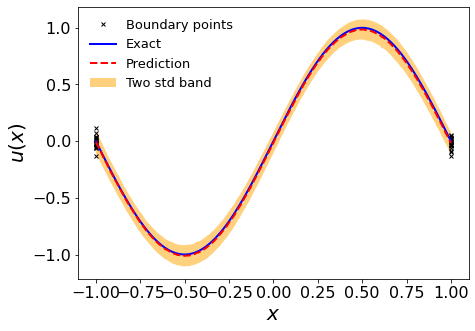

In [6]:
# Visualize the generated data
X_u = np.vstack((np.ones(shape=(N_u,1))*(1.0),np.ones(shape=(N_u,1))*(-1.0)))
Y_u = XY_u[:,1][:,None]

X_test = np.linspace(-1, 1, 201)[:, None] # Y_test keeps the same

mu_pred = np.mean(samples, axis = 1)    
sigma_pred = np.var(samples, axis = 1)
# Plot the prediction with the uncertainty versus the reference solution

ax = plt.figure(figsize=(7,5))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(X_u, Y_u, 'kx', markersize = 4, label = "Boundary points")
lower = mu_pred - 2.0*np.sqrt(sigma_pred)
upper = mu_pred + 2.0*np.sqrt(sigma_pred)
plt.fill_between(X_test.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
plt.plot(X_test,Y_test,'b-', label = "Exact", linewidth=2)
plt.plot(X_test, mu_pred, 'r--', label = "Prediction", linewidth=2)
plt.xlabel('$x$',fontsize=20)
plt.ylabel('$u(x)$',fontsize=20)
plt.legend(loc='upper left', frameon=False, prop={'size': 13})
plt.show()

We plot the histogram of the generated/simulated random boundary data.

D:\Softwares\miniconda3\envs\gyh_tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Softwares\miniconda3\envs\gyh_tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


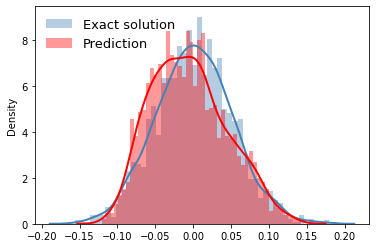

D:\Softwares\miniconda3\envs\gyh_tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Softwares\miniconda3\envs\gyh_tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


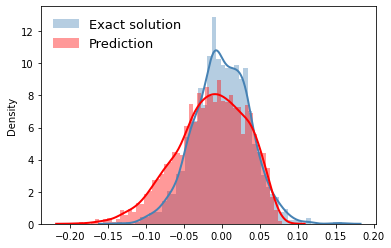

D:\Softwares\miniconda3\envs\gyh_tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Softwares\miniconda3\envs\gyh_tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


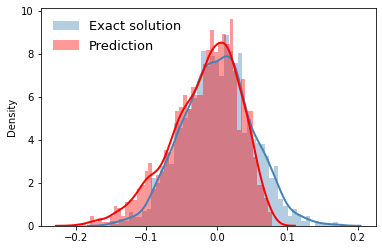

In [7]:
Y1 = samples[0,:]
Y2 = np.random.normal(loc=0,scale=0.05,size=2000)
plt.figure()
sns.distplot(Y2, hist=True, kde=True, bins=50, color='steelblue', hist_kws={'edgecolor':'None'}, kde_kws={'linewidth':2}, label='Exact solution')
sns.distplot(Y1, hist=True, kde=True, bins=50, color='red', hist_kws={'edgecolor':'None'}, kde_kws={'linewidth':2}, label="Prediction")
plt.legend(loc='upper left', frameon=False, prop={'size': 13})
plt.show()

Y1 = samples[100,:]
Y2 = scipy.io.loadmat('./ODE2000.mat')['U'].T[100,:]
plt.figure()
sns.distplot(Y2, hist=True, kde=True, bins=50, color='steelblue', hist_kws={'edgecolor':'None'}, kde_kws={'linewidth':2}, label='Exact solution')
sns.distplot(Y1, hist=True, kde=True, bins=50, color='red', hist_kws={'edgecolor':'None'}, kde_kws={'linewidth':2}, label="Prediction")
plt.legend(loc='upper left', frameon=False, prop={'size': 13})
plt.show()

Y1 = samples[200,:]
Y2 = np.random.normal(loc=0,scale=0.05,size=2000)
plt.figure()
sns.distplot(Y2, hist=True, kde=True, bins=50, color='steelblue', hist_kws={'edgecolor':'None'}, kde_kws={'linewidth':2}, label='Exact solution')
sns.distplot(Y1, hist=True, kde=True, bins=50, color='red', hist_kws={'edgecolor':'None'}, kde_kws={'linewidth':2}, label="Prediction")
plt.legend(loc='upper left', frameon=False, prop={'size': 13})
plt.show()

The following part shows the relative error during training. Our algorithm converges after 8 thousand iterations. 

In [3]:
! python run.py train --hparam='basic_params1'

--------------Begin Training-----------------
itr 2000, rel_error is 3.901123e-01 r2_loss is 0.000555, W loss is 0.045531; Time: 28.015262.

itr 4000, rel_error is 3.540329e-01 r2_loss is 0.000106, W loss is 0.037115; Time: 25.012441.

itr 6000, rel_error is 2.419092e-01 r2_loss is 0.000095, W loss is 0.025482; Time: 25.081248.

itr 8000, rel_error is 8.113504e-03 r2_loss is 0.000075, W loss is -0.011728; Time: 24.937561.

itr 10000, rel_error is 2.792417e-02 r2_loss is 0.000013, W loss is -0.028936; Time: 25.031247.

itr 12000, rel_error is 4.486097e-02 r2_loss is 0.000018, W loss is -0.022027; Time: 24.999932.

itr 14000, rel_error is 1.705527e-02 r2_loss is 0.000014, W loss is -0.003111; Time: 24.953288.

itr 16000, rel_error is 4.014924e-03 r2_loss is 0.000121, W loss is -0.017024; Time: 25.034846.

itr 18000, rel_error is 8.505513e-03 r2_loss is 0.000006, W loss is -0.008598; Time: 25.011948.

itr 20000, rel_error is 1.554206e-02 r2_loss is 0.000006, W loss is -0.002676; Time: 24.

2021-07-31 15:16:26.113141: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library cudart64_101.dll
2021-07-31 15:16:28.245492: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library nvcuda.dll
2021-07-31 15:16:28.274492: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-07-31 15:16:28.278164: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: GAOYihang
2021-07-31 15:16:28.278221: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: GAOYihang
2021-07-31 15:16:28.278618: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow w

D:\Softwares\miniconda3\envs\gyh_tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Softwares\miniconda3\envs\gyh_tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


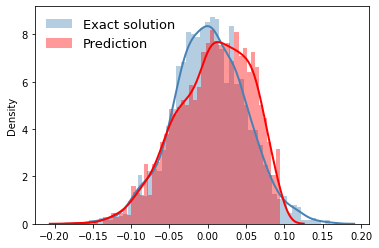

D:\Softwares\miniconda3\envs\gyh_tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Softwares\miniconda3\envs\gyh_tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


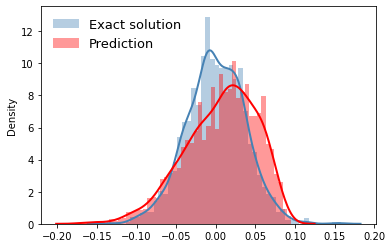

D:\Softwares\miniconda3\envs\gyh_tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Softwares\miniconda3\envs\gyh_tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


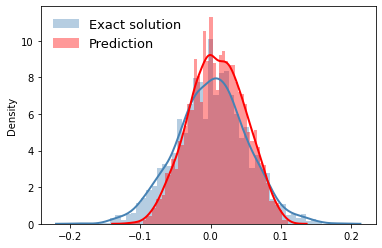

In [9]:
samples = np.load("data_0.05.npy")

Y1 = samples[0,:]
Y2 = np.random.normal(loc=0,scale=0.05,size=2000)
plt.figure()
sns.distplot(Y2, hist=True, kde=True, bins=50, color='steelblue', hist_kws={'edgecolor':'None'}, kde_kws={'linewidth':2}, label='Exact solution')
sns.distplot(Y1, hist=True, kde=True, bins=50, color='red', hist_kws={'edgecolor':'None'}, kde_kws={'linewidth':2}, label="Prediction")
plt.legend(loc='upper left', frameon=False, prop={'size': 13})
plt.show()

Y1 = samples[100,:]
Y2 = scipy.io.loadmat('./ODE2000.mat')['U'].T[100,:]
plt.figure()
sns.distplot(Y2, hist=True, kde=True, bins=50, color='steelblue', hist_kws={'edgecolor':'None'}, kde_kws={'linewidth':2}, label='Exact solution')
sns.distplot(Y1, hist=True, kde=True, bins=50, color='red', hist_kws={'edgecolor':'None'}, kde_kws={'linewidth':2}, label="Prediction")
plt.legend(loc='upper left', frameon=False, prop={'size': 13})
plt.show()

Y1 = samples[200,:]
Y2 = np.random.normal(loc=0,scale=0.05,size=2000)
plt.figure()
sns.distplot(Y2, hist=True, kde=True, bins=50, color='steelblue', hist_kws={'edgecolor':'None'}, kde_kws={'linewidth':2}, label='Exact solution')
sns.distplot(Y1, hist=True, kde=True, bins=50, color='red', hist_kws={'edgecolor':'None'}, kde_kws={'linewidth':2}, label="Prediction")
plt.legend(loc='upper left', frameon=False, prop={'size': 13})
plt.show()